<a href="https://colab.research.google.com/github/intelligent-environments-lab/occupant_centric_grid_interactive_buildings_course/blob/main/src/notebooks/tutorials/introduction_to_energy_plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to EnergyPlus
---

[EnergyPlus](https://energyplus.net) is a physics-based whole building energy performance simulation software. It is widely used in academia and academia by building energy professionals for design optimization, retrofit analyses, energy audits, and performance verification to mention a few.

One way to use EnergyPlus is to build an energy model from scratch. However, this approach requires a significant expertise and time investment as well as access to data that may not be readily available. The other route which we adopt in this class is to take advantage of stock energy models that have been developed and vetted by experts in the energy research field. To this end, we will make use of the [End-Use Load Profiles (EULP) for the U.S. Building Stock](https://www.nrel.gov/buildings/end-use-load-profiles.html) dataset that has about 900 thousand energy models representing the residential and commercial building stock in the United States. The dataset has had a few releases over the years however we will make use of the `resstock-amy2018-2021-release-1`. This [dataset](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=nrel-pds-building-stock%2Fend-use-load-profiles-for-us-building-stock%2F2021%2Fresstock_tmy3_release_1%2F) is
the 2021 release of about 500,000 energy models and their simulation results for a typical meteorological year weather.

In this tutorial, you will learn how to install EnergyPlus, run a simulation on an EULP energy model, and visualize its results using a _Pythonic_ interface.

## Installing EnergyPlus
---

There are two ways you could go about installing EnergyPlus. The first is to install it locally in your machine and always have it when you need it. Note that if you take this approach, you will also have to run this notebook locally as Colab is unable to point to your local file structure.

The second way, and recommended for this class, is to install it temporarily in the Colab environment runtime. This approach is local-machine-agnostic and will help avoid typically installation problems that are specific to your local machine.

Whichever approach you choose, make sure you install the `v9.6.0` version of EnergyPlus as it is what will be compatible with the dataset we use.

To install to local computer, [download the installer for your specific platform](https://github.com/NREL/EnergyPlus/releases/tag/v9.6.0).

To install to the current Colab environment runtime, uncomment and execute the next cell:

In [ ]:
# # set environment variables for installation
# import os

# os.environ['OCCGEB_ENERGY_PLUS_VERSION'] = "9.6.0"
# os.environ['OCCGEB_ENERGY_PLUS_INSTALLER_FILENAME']= f"EnergyPlus-{os.environ['OCCGEB_ENERGY_PLUS_VERSION']}-f420c06a69-Linux-Ubuntu20.04-x86_64.sh"
# os.environ['OCCGEB_ENERGY_PLUS_INSTALLER_URL'] =f"https://github.com/NREL/EnergyPlus/releases/download/v{os.environ['OCCGEB_ENERGY_PLUS_VERSION']}/{os.environ['OCCGEB_ENERGY_PLUS_INSTALLER_FILENAME']}"

# # remove existing installer if any
# !rm -f $PWD/$OCCGEB_ENERGY_PLUS_INSTALLER_FILENAME
# !wget $OCCGEB_ENERGY_PLUS_INSTALLER_URL

# # install
# !chmod +x $PWD/$OCCGEB_ENERGY_PLUS_INSTALLER_FILENAME
# !echo -e "yes\n" | sudo $PWD/$OCCGEB_ENERGY_PLUS_INSTALLER_FILENAME

# # to capture C-level stdout/stderr pipes in Python
# !pip install wurlitzer

# # print EnergyPlus version to confirm energyplus command is executable
# print('\nEnergyPlus Version:')
# !energyplus -version

# # # delete installer
# !rm -f $PWD/$OCCGEB_ENERGY_PLUS_INSTALLER_FILENAME

Confirm that the last printout above reports that `EnergyPlus Version 9.6.0` was installed.

## Interfacing with EULP dataset
---

We will test our installation by simulating a random single-family attached building in Fulton County (Atlanta), Goergia (like our smart neighborhood building). We have written a Python wrapper called `DOE_XStock` around the EULP dataset that allows use to easily query its metadata and run simulations. First we will install this wrapper and other relevant dependencies:

In [ ]:
# wrapper for EULP dataset
# (best to reinstall to get new changes as it is currently under development)
!pip install --upgrade --force-reinstall git+https://github.com/intelligent-environments-lab/DOE_XStock.git@v1-develop

# for plotting figures
!pip install matplotlib

### How to retrieve building metadata in EULP dataset

With the wrapper installed we can now interface with the dataset. The models in the EULP dataset are referenced using building IDs. Let us return the metadata of all single-family attached building in Fulton County. We begin by making the necessary imports:

In [3]:
import os
from doe_xstock.end_use_load_profiles import EndUseLoadProfiles
import matplotlib.pyplot as plt
import pandas as pd

Next we initialize the dataset:

In [4]:
eulp = EndUseLoadProfiles(
    dataset_type='resstock',
    weather_data='tmy3',
    year_of_publication=2021,
    release=1,
)

We can now return the metadata:

In [5]:
metadata = eulp.metadata.metadata.get(filters={
    'in.resstock_county_id': ['GA, Fulton County'],
    'in.geometry_building_type_recs': ['Single-Family Attached'],
})

with pd.option_context('display.max_columns', None):
    display(metadata.head())
    print('Number of represented single-family attached buildings in GA, Fulton County:', metadata.shape[0])

,in.county,in.puma,in.ashrae_iecc_climate_zone_2004,in.building_america_climate_zone,in.iso_rto_region,applicability,weight,in.sqft,in.ahs_region,in.applicable,in.bathroom_spot_vent_hour,in.bedrooms,in.cec_climate_zone,in.ceiling_fan,in.census_division,in.census_division_recs,in.census_region,in.clothes_dryer,in.clothes_washer,in.clothes_washer_presence,in.cooking_range,in.cooling_setpoint,in.cooling_setpoint_has_offset,in.cooling_setpoint_offset_magnitude,in.cooling_setpoint_offset_period,in.corridor,in.dehumidifier,in.dishwasher,in.door_area,in.doors,in.ducts,in.eaves,in.electric_vehicle,in.geometry_attic_type,in.geometry_building_horizontal_location_mf,in.geometry_building_horizontal_location_sfa,in.geometry_building_level_mf,in.geometry_building_number_units_mf,in.geometry_building_number_units_sfa,in.geometry_building_type_acs,in.geometry_building_type_height,in.geometry_building_type_recs,in.geometry_floor_area,in.geometry_floor_area_bin,in.geometry_foundation_type,in.geometry_garage,in.geometry_stories,in.geometry_stories_low_rise,in.geometry_wall_exterior_finish,in.geometry_wall_type,in.geometry_wall_type_and_exterior_finish,in.has_pv,in.heating_fuel,in.heating_setpoint,in.heating_setpoint_has_offset,in.heating_setpoint_offset_magnitude,in.heating_setpoint_offset_period,in.holiday_lighting,in.hot_water_distribution,in.hot_water_fixtures,in.hvac_cooling_efficiency,in.hvac_cooling_type,in.hvac_has_ducts,in.hvac_has_shared_system,in.hvac_has_zonal_electric_heating,in.hvac_heating_efficiency,in.hvac_heating_type,in.hvac_heating_type_and_fuel,in.hvac_secondary_heating_efficiency,in.hvac_secondary_heating_type_and_fuel,in.hvac_shared_efficiencies,in.hvac_system_is_faulted,in.hvac_system_single_speed_ac_airflow,in.hvac_system_single_speed_ac_charge,in.hvac_system_single_speed_ashp_airflow,in.hvac_system_single_speed_ashp_charge,in.infiltration,in.insulation_ceiling,in.insulation_floor,in.insulation_foundation_wall,in.insulation_roof,in.insulation_slab,in.insulation_wall,in.interior_shading,in.lighting,in.lighting_interior_use,in.lighting_other_use,in.location_region,in.mechanical_ventilation,in.misc_extra_refrigerator,in.misc_freezer,in.misc_gas_fireplace,in.misc_gas_grill,in.misc_gas_lighting,in.misc_hot_tub_spa,in.misc_pool,in.misc_pool_heater,in.misc_pool_pump,in.misc_well_pump,in.natural_ventilation,in.neighbors,in.occupants,in.orientation,in.overhangs,in.plug_load_diversity,in.plug_loads,in.pv_orientation,in.pv_system_size,in.radiant_barrier,in.range_spot_vent_hour,in.reeds_balancing_area,in.refrigerator,in.roof_material,in.schedules,in.setpoint_demand_response,in.solar_hot_water,in.state,in.units_represented,in.usage_level,in.vacancy_status,in.vintage,in.vintage_acs,in.water_heater_efficiency,in.water_heater_fuel,in.water_heater_in_unit,in.weather_file_city,in.weather_file_latitude,in.weather_file_longitude,in.window_areas,in.windows,in.nhgis_county_gisjoin,in.nhgis_puma_gisjoin,in.state_name,in.american_housing_survey_region,in.weather_file_2018,in.weather_file_TMY3,in.resstock_county_id,in.resstock_puma_id,out.electricity.bath_fan.energy_consumption,out.electricity.bath_fan.energy_consumption_intensity,out.electricity.ceiling_fan.energy_consumption,out.electricity.ceiling_fan.energy_consumption_intensity,out.electricity.clothes_dryer.energy_consumption,out.electricity.clothes_dryer.energy_consumption_intensity,out.electricity.clothes_washer.energy_consumption,out.electricity.clothes_washer.energy_consumption_intensity,out.electricity.cooking_range.energy_consumption,out.electricity.cooking_range.energy_consumption_intensity,out.electricity.cooling.energy_consumption,out.electricity.cooling.energy_consumption_intensity,out.electricity.dishwasher.energy_consumption,out.electricity.dishwasher.energy_consumption_intensity,out.electricity.ext_holiday_light.energy_consumption,out.electricity.ext_holiday_light.energy_consumption_intensity,out.electricity.exterior_lighting.energy_consumption,out.electricity.exterior_lighting.

Number of represented single-family attached buildings in GA, Fulton County: 116


From the printout, there are 116 buildings that match our filter criteria. We will now randomly pick a building to simulate:

In [6]:
BLDG_ID = metadata.sample(1, random_state=0).iloc[0].name
print('Picked building ID:', BLDG_ID)

Picked building ID: 44304


We can also retrieve a dictionary containing all the metadata for this particular building:

In [7]:
print(BLDG_ID, 'metadata:')
display(eulp.get_building(BLDG_ID).metadata)

44304 metadata:


{'bldg_id': 44304,
 'in.county': 'G1301210',
 'in.puma': 'G13004600',
 'in.ashrae_iecc_climate_zone_2004': '3A',
 'in.building_america_climate_zone': 'Mixed-Humid',
 'in.iso_rto_region': 'None',
 'applicability': True,
 'weight': 242.13101272727272,
 'in.sqft': 317.0,
 'in.ahs_region': 'CBSA Atlanta-Sandy Springs-Roswell, GA',
 'in.applicable': True,
 'in.bathroom_spot_vent_hour': 'Hour5',
 'in.bedrooms': '2',
 'in.cec_climate_zone': 'None',
 'in.ceiling_fan': 'Standard Efficiency',
 'in.census_division': 'South Atlantic',
 'in.census_division_recs': 'South Atlantic',
 'in.census_region': 'South',
 'in.clothes_dryer': 'Electric, 80% Usage',
 'in.clothes_washer': 'Standard, 80% Usage',
 'in.clothes_washer_presence': 'Yes',
 'in.cooking_range': 'Electric, 80% Usage',
 'in.cooling_setpoint': '76F',
 'in.cooling_setpoint_has_offset': 'Yes',
 'in.cooling_setpoint_offset_magnitude': '2F',
 'in.cooling_setpoint_offset_period': 'Night Setup -1h',
 'in.corridor': 'Not Applicable',
 'in.dehumidi

## Simulating an EULP building energy model
---

Simulating energy models is quite straightforward using the `DOE_XStock` wrapper. However, there is one variable, a filpath, you need to retrieve called the `EnergyPlus IDD`. `IDD` stands for `Input Data Dictionary` and is an ASCII (text) file containing a list of all possible EnergyPlus objects and a specification of the data each object requires. It is EnergyPlus version specific and helps the internal model editor in `DOE_XStock` aware of the _version language_.

If you installed EnergyPlus within Colab then, the path defined in the next cell points to the correct `IDD`.

For local installations, it will be in a similar path as below but the root will be specific to your machine. Mac users should be able to find the EnergyPlus directory in their Applications directory. Once found, replace the `IDD_FILEPATH` below with the correct path:

In [8]:
IDD_FILEPATH = '/usr/local/EnergyPlus-9-6-0/PreProcess/IDFVersionUpdater/V9-6-0-Energy+.idd'

if os.path.isfile(IDD_FILEPATH):
    print('IDD exists!')
else:
    print('Provided IDD does not exist:', IDD_FILEPATH)

IDD exists!


To then simulate the building is as simple as parsing its ID to the relevant function with the `IDD_FILEPATH` we have defined:

In [9]:
SIMULATION_ID = f'simulation-{BLDG_ID}'
building = eulp.simulate_building(
    BLDG_ID,
    IDD_FILEPATH,
    simulation_id=SIMULATION_ID,
    output_directory=SIMULATION_ID,
    default_output_variables=True,
)

## Analyzing and visualizing results from simulation
---

With our simulation completed, all that is left is to look at how the building performed with its as provided parameters seen in its metadata printout. EnergyPlus exports results in a `.sqlite` file as well as `.csv` file. It is up to you which output you want to work with. The `SQLite` database is easier to use when trying to manage results from many variables and thermal zones in a building. The `CSV` text file is a more familiar interface for most people. Let us start by using the `.csv` to retrieve and plot the outdoor and indoor dry-bulb temperature as well as the air system cooling and heating rates in any of the zones of the building. We will use the `SQLite` approach in a later tutorial.

In [10]:
results = building.simulator.get_output_variables_csv()

with pd.option_context('display.max_columns', None):
    display(results)

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Relative Humidity [%](TimeStep),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),LIVING ZONE:Zone People Occupant Count [](TimeStep),LIVING ZONE:Zone Lights Electricity Rate [W](TimeStep),LIVING ZONE:Zone Electric Equipment Electricity Rate [W](TimeStep),RES BATH:Other Equipment Convective Heating Energy [J](TimeStep),RES BATH:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES AC ASYS SUPDCNTOLVEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES AC ASYS SUPDCNTOLVEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES AC ASYS SUPLATLKTOLVEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES AC ASYS SUPLATLKTOLVEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES AC ASYS SUPSLKTOLVEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES AC ASYS SUPSLKTOLVEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES FUR ELECTRIC ASYS SUPDCNTOLVEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES FUR ELECTRIC ASYS SUPDCNTOLVEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES FUR ELECTRIC ASYS SUPLATLKTOLVEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES FUR ELECTRIC ASYS SUPLATLKTOLVEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES FUR ELECTRIC ASYS SUPSLKTOLVEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES FUR ELECTRIC ASYS SUPSLKTOLVEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES HOT WATER DISTRIBUTION:Other Equipment Convective Heating Energy [J](TimeStep),RES HOT WATER DISTRIBUTION:Other Equipment Convective Heating Rate [W](TimeStep),RES SHOWER:Other Equipment Convective Heating Energy [J](TimeStep),RES SHOWER:Other Equipment Convective Heating Rate [W](TimeStep),RES SINK:Other Equipment Convective Heating Energy [J](TimeStep),RES SINK:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES AC ASYS RETDCNTOPLEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES AC ASYS RETDCNTOPLEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES AC ASYS RETLATLKEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES AC ASYS RETLATLKEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES AC ASYS RETSLKEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES AC ASYS RETSLKEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES FUR ELECTRIC ASYS RETDCNTOPLEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES FUR ELECTRIC ASYS RETDCNTOPLEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES FUR ELECTRIC ASYS RETLATLKEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES FUR ELECTRIC ASYS RETLATLKEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES FUR ELECTRIC ASYS RETSLKEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES FUR ELECTRIC ASYS RETSLKEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES AC ASYS RETDCNTOAHEQUIP:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES AC ASYS RETDCNTOAHEQUIP:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES AC ASYS SUPDCNTOAHEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES AC ASYS SUPDCNTOAHEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES AC ASYS SUPLATLKTOAHEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES AC ASYS SUPLATLKTOAHEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES AC ASYS SUPSLKTOAHEQ:Other Equipment Convective Heating Energy [J](TimeStep),RES DS RES AC ASYS SUPSLKTOAHEQ:Other Equipment Convective Heating Rate [W](TimeStep),RES DS RES FUR ELECTRIC ASYS RETDCNTOAHEQUIP:Other Equipment Convective Heating Energy [J](TimeSte

From inspecting the dataframe, we can find the four relevant columns. Also notice that by default, the simulation is on a 15-minute time step and is done for a full year?

In [11]:
columns = [
    "Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",
    "LIVING ZONE:Zone Air Temperature [C](TimeStep)",
    "LIVING ZONE:Zone Air System Sensible Heating Rate [W](TimeStep)",
    "LIVING ZONE:Zone Air System Sensible Cooling Rate [W](TimeStep)",
]

Sometimes, you may not know what variables are availble or reported from the simulation. There are two output files that can help with this. They are:

1. *.rdd (Report variable Data Dictionary): list of output variables available from the run.
2. *.mdd (report Meter Data Ditionary): list of output meters available from the run.

They are in the same path as the simulation results. You can locate the path by executing the following:

In [12]:
print('Simulation output directory:', building.simulator.output_directory)

Simulation output directory: /content/simulation-44304


Those two files have a long list of variables that may be intimidating if you have no idea what they reference or come from. The easiest way to learn about them is either through a Google search or directly search the [EnergyPlus documentation](https://bigladdersoftware.com/epx/docs/9-6/input-output-reference/).

Now let us go back to visualizing our results:

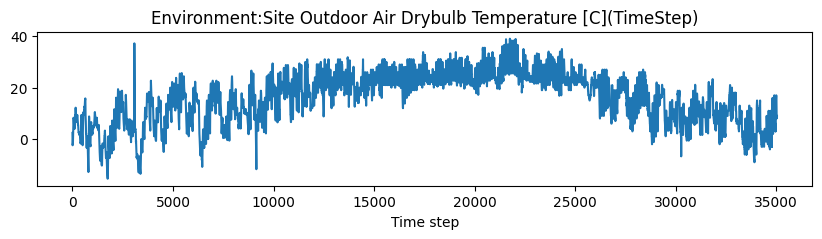

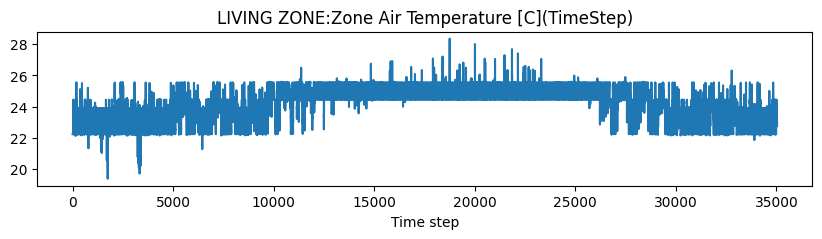

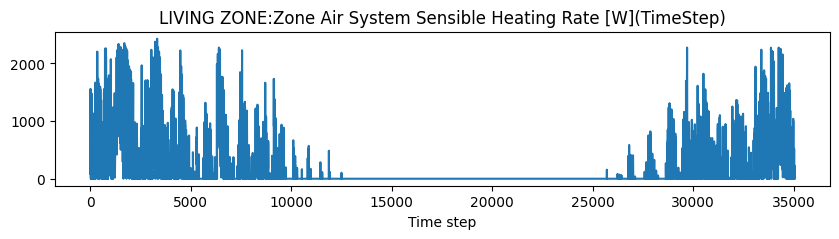

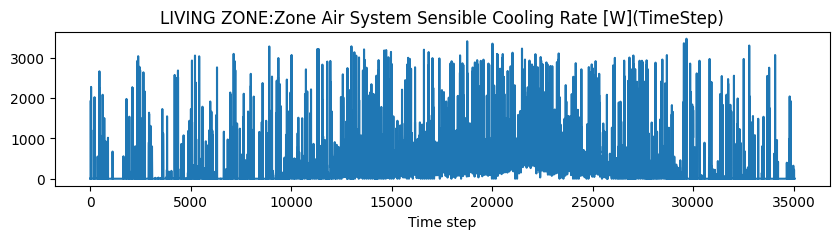

In [13]:
for c in columns:
    fig, ax = plt.subplots(1, 1, figsize=(10, 2.0))
    x = results.index
    y = results[c]
    ax.plot(x, y)
    ax.set_xlabel('Time step')
    ax.set_title(c)
    plt.show()

Do you spot anything interesting from the figures? You can now go back to simulate a different building if you wish and perhaps compare its results to this.

## Conclusion
---

We have learned how to install EnergyPlus and how to interface with the End-Use Load Profiles (EULP) for the U.S. Building Stock as well as run simulations on its energy models. This tutorial was short but prepares you for longer tutorials where you will run a number of simulations.

It is encouraged that you take some time to read through the references and further reading links. Most importantly, practice, practice, practice!

## Further reading and references
---

1. [Introduction to building energy performance simulation](https://github.com/intelligent-environments-lab/occupant_centric_grid_interactive_buildings_course/blob/main/src/lectures/CE397_OCCGEB_Sp24_05.pdf)
4. [End-Use Load Profiles (EULP) for the U.S. Building Stock](https://www.nrel.gov/buildings/end-use-load-profiles.html)
2. [EnergyPlus quickstart](https://energyplus.net/quick-start)
2. [EnergyPlus](https://energyplus.net)
2. [EnergyPlus documentation](https://bigladdersoftware.com/epx/docs/9-6/input-output-reference/)
3. [EULP DOE_XStock wrapper documentation](https://github.com/intelligent-environments-lab/DOE_XStock/tree/v1-develop)
5. [Eppy tutorial for manipulating EnergyPlus IDF file](https://eppy.readthedocs.io/en/latest/Main_Tutorial.html)